Importing libraries

In [64]:
import numpy as np
import pandas as pd
import json 
import geocoder
from pandas.io.json import json_normalize 

from geopy.geocoders import Nominatim 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans

import folium 

The districts are represented as postal codes obtained from the government postal service. Data is retrieved from csv file.

In [2]:
df=pd.read_csv('istanbul.csv')
df.head()

,postalcode,borough,dIstrIct
0,34010,ZEYTINBURNU,TOPKAPI
1,34015,ZEYTINBURNU,SEYITNIZAM
2,34020,ZEYTINBURNU,TELSIZ
3,34022,BESIKTAS,ABBASAGA
4,34025,ZEYTINBURNU,CIRPICI


Latitude and longitude function

In [3]:
def get_lat_lon(postal_code):
    lat_lon_coords = None
    while(lat_lon_coords is None):
        g = geocoder.arcgis('{}, Istanbul, Turkey'.format(postal_code))
        lat_lon_coords = g.latlng
    return lat_lon_coords

Getting lat-lon values for postal codes (it takes time!)

In [4]:
postal_codes = df['postalcode']    
coords = [get_lat_lon(postal_code) for postal_code in postal_codes.tolist()]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df.head(20)

,postalcode,borough,dIstrIct,Latitude,Longitude
0,34010,ZEYTINBURNU,TOPKAPI,41.019560,28.911448
1,34015,ZEYTINBURNU,SEYITNIZAM,41.010765,28.911920
2,34020,ZEYTINBURNU,TELSIZ,40.992104,28.905205
3,34022,BESIKTAS,ABBASAGA,41.046519,29.006215
4,34025,ZEYTINBURNU,CIRPICI,40.992650,28.897785
5,34030,BAYRAMPASA,NUMUNEBAG,41.039963,28.913460
6,34035,BAYRAMPASA,ALTINTEPSI,41.036630,28.898121
7,34040,BAYRAMPASA,MURATPASA,41.050654,28.902860
8,34045,BAYRAMPASA,YILDIRIM,41.057928,28.890880
9,34050,EYUPSULTAN,EYUP,41.044327,28.934055


Importing the districts with lat-lon values for further studies

In [104]:
# import as csv
df.to_csv('istanbul_w_lat_lon.csv', index=False)

The geograpical coordinate of Istanbul

In [6]:
address = 'Istanbul, TURKEY'

geolocator = Nominatim(user_agent="Istanbul")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


Locating the districts on folium map

In [7]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, dIstrIct in zip(df['Latitude'], df['Longitude'], df['borough'], df['dIstrIct']):
    label = '{}, {}'.format(dIstrIct, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
    
map_istanbul

Foursquare API parameters

In [8]:
CLIENT_ID = 'AECK5FXJOXF3NRZXUIJAHSKRB1BR1MTWPYOYXP2BLGSOWYGV' # your Foursquare ID
CLIENT_SECRET = '3RICDETL0FRPMIWESWWNYGBNF25GQJXY4CZ21T4F50SODQCE' # your Foursquare Secret
VERSION = '20191201' # Foursquare API version, especially from 2019 :)

# c: AECK5FXJOXF3NRZXUIJAHSKRB1BR1MTWPYOYXP2BLGSOWYGV
# s: 3RICDETL0FRPMIWESWWNYGBNF25GQJXY4CZ21T4F50SODQCE


In order to get venue information from Foursquare API, function is defined

In [9]:
import requests

radius=500
LIMIT=100

def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pk, name, lat, lng in zip(postalcodes, names, latitudes, longitudes):
        print(pk, name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            

        results = requests.get(url).json()["response"]['groups'][0]['items']
        

        venues_list.append([(
            pk,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode','District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting venue information from Foursquare API

In [10]:
istanbul_venues = getNearbyVenues(postalcodes=df['postalcode'],
                                   names=df['dIstrIct'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

34010 TOPKAPI
34015 SEYITNIZAM
34020 TELSIZ
34022 ABBASAGA
34025 CIRPICI
34030 NUMUNEBAG
34035 ALTINTEPSI
34040 MURATPASA
34045 YILDIRIM
34050 EYUP
34055 RAMI
34060 ALIBEYKOY
34065 YESILPINAR
34070 CIRCIR
34075 KEMERBURGAZ
34076 ISIKLAR
34077 GOKTURK
34080 ISKENDERPASA
34083 ZEYREK
34087 BALAT
34091 KARAGUMRUK
34093 TOPKAPI
34096 AKSARAY
34098 KOCAMUSTAFAPASA
34104 SEHREMINI
34107 YEDIKULE
34110 EMINONU
34112 SIRKECI
34116 TAHTAKALE
34120 MAHMUTPASA
34122 SULTANAHMET
34126 BAYAZIT
34130 KUMKAPI
34134 VEFA
34140 ZEYTINLIK
34142 CEVIZLIK
34145 KARTALTEPE
34146 OSMANIYE
34147 ZUHURATBABA
34149 YESILKOY
34153 FLORYA
34158 ATAKOY
34160 AKINCILAR
34164 GUNGOREN
34165 SANAYI
34173 TOZKOPARAN
34180 BAHCELIEVLER
34188 SIRINEVLER
34197 YENIBOSNA
34200 BAGCILAR
34212 GUNESLI
34218 MAHMUTBEY
34220 ESENLER
34225 KARABAYIR
34230 ATISALANI
34235 SANAYI
34240 YILDIZTABYA
34245 GAZIOSMANPASA
34250 KUCUKKOY
34255 MEVLANA
34260 ZUBEYDEHANIM
34265 SULTANCIFTLIGI
34270 SULTANGAZI
34275 ARNAVUTKOY
34277 BAK

Here we have the venues:

In [11]:
istanbul_venues.head(10)

,PostalCode,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,34010,TOPKAPI,41.01956,28.911448,Selanik Kahvecisi,41.018032,28.912180,Coffee Shop
1,34010,TOPKAPI,41.01956,28.911448,Mucco Cafe,41.019773,28.911514,Café
2,34010,TOPKAPI,41.01956,28.911448,Game of Burger,41.017291,28.911139,Burger Joint
3,34010,TOPKAPI,41.01956,28.911448,Kadayıfzade Cevizlibağ,41.018552,28.910799,Cafeteria
4,34010,TOPKAPI,41.01956,28.911448,Starbucks,41.018141,28.911913,Coffee Shop
5,34010,TOPKAPI,41.01956,28.911448,Club House (Fitness Center),41.018929,28.910504,Gym / Fitness Center
6,34010,TOPKAPI,41.01956,28.911448,Haggar,41.018320,28.912249,Restaurant
7,34010,TOPKAPI,41.01956,28.911448,Hill's Coffee & Food Studio,41.018823,28.910631,Food Court
8,34010,TOPKAPI,41.01956,28.911448,Vefa Turkcell Iletisim Merkezi,41.021079,28.913915,Mobile Phone Shop
9,34010,TOPKAPI,41.01956,28.911448,Starbucks,41.018341,28.911968,Coffee Shop


In [12]:
istanbul_venues.shape

(10490, 8)

Unique categories in Istanbul

In [13]:
print('There are {} unique categories in Istanbul.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 441 unique categories in Istanbul.


Distribution of unique categories:

In [14]:
istanbul_venues['Venue Category'].value_counts()

Café                        1286
Turkish Restaurant           475
Restaurant                   425
Coffee Shop                  367
Bakery                       300
                            ... 
Bike Rental / Bike Share       1
Warehouse Store                1
Swiss Restaurant               1
Comedy Club                    1
Szechuan Restaurant            1
Name: Venue Category, Length: 441, dtype: int64

We have number of categories which are not enough for analysis. Dropping the categories with a number of less than or equal to 20 (by experience :))

In [15]:
istanbul_venues_red=istanbul_venues.groupby('Venue Category').filter(lambda x : len(x)>20)
istanbul_venues_red['Venue Category'].value_counts()

Café                          1286
Turkish Restaurant             475
Restaurant                     425
Coffee Shop                    367
Bakery                         300
                              ... 
Construction & Landscaping      21
Shoe Store                      21
Auto Garage                     21
Beach                           21
Salon / Barbershop              21
Name: Venue Category, Length: 97, dtype: int64

Bar plot of distribution. We have cafe, restaurant, bakery and hotels with high distribution.

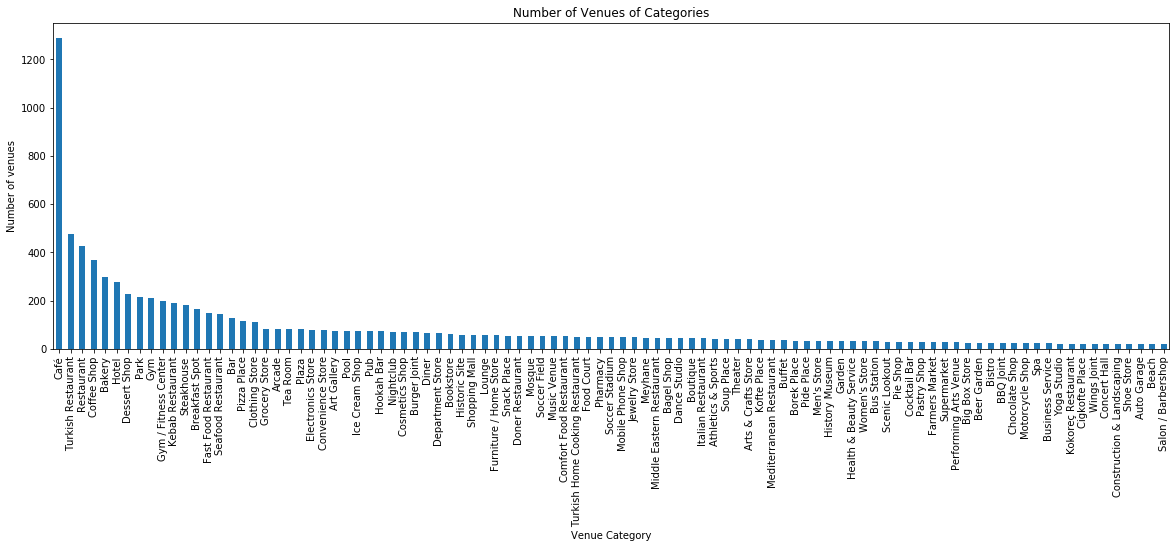

In [41]:
# step 2: plot data
Venue_cat_num=istanbul_venues_red['Venue Category'].value_counts()
Venue_cat_num.plot(kind='bar', figsize=(20, 6))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of Venues of Categories') # add title to the plot

plt.show()

One-hot encoding for categories:

In [17]:
istanbul_onehot = pd.get_dummies(istanbul_venues_red[['Venue Category']], prefix="", prefix_sep="")

istanbul_onehot['PostalCode'] = istanbul_venues_red['PostalCode'] 
istanbul_onehot['District'] = istanbul_venues_red['District'] 

fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head(10)

,District,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,...,Steakhouse,Supermarket,Tea Room,Theater,Turkish Home Cooking Restaurant,Turkish Restaurant,Wings Joint,Women's Store,Yoga Studio,PostalCode
0,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
1,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
2,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
4,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
5,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
6,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
7,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
8,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
9,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010
10,TOPKAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34010


In [18]:
istanbul_grouped = istanbul_onehot.groupby('PostalCode').sum().reset_index()
istanbul_grouped.head(10)

,PostalCode,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,...,Spa,Steakhouse,Supermarket,Tea Room,Theater,Turkish Home Cooking Restaurant,Turkish Restaurant,Wings Joint,Women's Store,Yoga Studio
0,34010,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
1,34015,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,2,0,0,0
2,34020,1,0,2,0,0,0,0,2,0,...,0,1,0,2,1,0,4,0,0,0
3,34022,0,0,0,0,0,1,0,2,7,...,0,0,0,0,1,0,3,0,0,1
4,34025,0,0,1,0,0,0,1,1,0,...,0,1,0,2,0,0,2,0,0,0
5,34030,1,0,1,1,0,0,1,0,0,...,0,1,0,0,1,0,3,1,0,0
6,34035,0,0,0,0,0,1,0,3,0,...,1,2,0,0,0,0,7,0,0,0
7,34040,1,0,1,0,0,0,2,1,1,...,0,0,0,0,0,0,2,0,1,0
8,34045,0,0,0,0,1,0,0,1,0,...,0,4,0,0,0,0,1,0,0,0
9,34050,1,0,0,0,0,0,0,1,0,...,0,1,0,2,0,0,3,0,0,0


In [19]:
istanbul_grouped.shape

(251, 98)

Listing the postalcodes/districts with its 5 most common categories

In [20]:
num_top_venues = 5
for postalcode in istanbul_grouped['PostalCode']:
    print("----",postalcode,"----")
    temp = istanbul_grouped[istanbul_grouped['PostalCode'] == postalcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- 34010 ----
                     venue  freq
0              Coffee Shop   6.0
1             Dessert Shop   4.0
2  Comfort Food Restaurant   3.0
3                     Café   3.0
4               Pide Place   2.0


---- 34015 ----
                venue  freq
0                Café  11.0
1          Restaurant   3.0
2    Kebab Restaurant   2.0
3  Turkish Restaurant   2.0
4          Food Court   2.0


---- 34020 ----
                  venue  freq
0      Department Store   5.0
1  Gym / Fitness Center   4.0
2        Clothing Store   4.0
3           Men's Store   4.0
4    Turkish Restaurant   4.0


---- 34022 ----
          venue  freq
0   Coffee Shop  19.0
1          Café  10.0
2           Pub   8.0
3           Bar   7.0
4  Burger Joint   4.0


---- 34025 ----
                  venue  freq
0                  Café   9.0
1            Restaurant   6.0
2  Gym / Fitness Center   3.0
3          Dessert Shop   3.0
4           Men's Store   2.0


---- 34030 ----
                venue  freq
0       

In order to examine; function is defined for most common categories

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

For each postalcode/district, we obtained 10 most common venue categories

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['PostalCode'] = istanbul_grouped['PostalCode']

for ind in np.arange(istanbul_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.shape

(251, 11)

In [23]:
district_venues_sorted.head(10)

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,34010,Coffee Shop,Dessert Shop,Comfort Food Restaurant,Café,Food Court,Furniture / Home Store,Pastry Shop,Restaurant,Pide Place,Turkish Restaurant
1,34015,Café,Restaurant,Turkish Restaurant,Food Court,Kebab Restaurant,Gym,Hotel,Park,Garden,Burger Joint
2,34020,Department Store,Men's Store,Turkish Restaurant,Gym / Fitness Center,Clothing Store,Dessert Shop,Restaurant,Ice Cream Shop,Fast Food Restaurant,Arts & Crafts Store
3,34022,Coffee Shop,Café,Pub,Bar,Performing Arts Venue,Burger Joint,Breakfast Spot,Chocolate Shop,Hookah Bar,Restaurant
4,34025,Café,Restaurant,Gym / Fitness Center,Dessert Shop,Men's Store,Turkish Restaurant,Tea Room,Grocery Store,Breakfast Spot,Pharmacy
5,34030,Café,Hotel,Turkish Restaurant,Soup Place,Park,Dessert Shop,Beer Garden,Men's Store,Gym / Fitness Center,Breakfast Spot
6,34035,Turkish Restaurant,Bus Station,Park,Bakery,Gym / Fitness Center,Steakhouse,Dessert Shop,Soup Place,Soccer Stadium,Restaurant
7,34040,Gym / Fitness Center,Café,Convenience Store,Turkish Restaurant,Bagel Shop,Arcade,Kofte Place,Pie Shop,Pharmacy,Music Venue
8,34045,Café,Hookah Bar,Steakhouse,Kebab Restaurant,Restaurant,Gym / Fitness Center,Furniture / Home Store,Food Court,Kofte Place,Dessert Shop
9,34050,Café,Turkish Restaurant,Breakfast Spot,Tea Room,Jewelry Store,Dessert Shop,Hotel,History Museum,Hookah Bar,Park


First, min-max scaler is applied to data, and finally k-means is applied for clustering

In [47]:
from sklearn.preprocessing import MinMaxScaler

istanbul_grouped_clustering = istanbul_grouped.drop('PostalCode', 1)


# Standarize features
scaler = MinMaxScaler()
istanbul_grouped_clustering_std = scaler.fit_transform(istanbul_grouped_clustering)

Sum_of_squared_distances = []

K = range(1,25)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(istanbul_grouped_clustering_std)
    Sum_of_squared_distances.append(km.inertia_)
    

In order to find the optimal k, we've examined the elbow shape of sum of squared distances

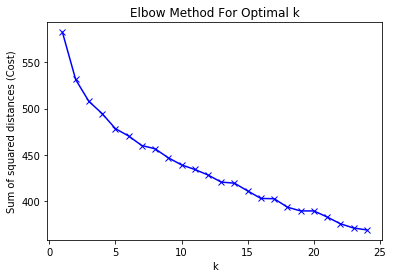

In [48]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (Cost)')
plt.title('Elbow Method For Optimal k')
plt.show()

We take 7 as k (someone could take 13, 16, 19 or something different, but it generates clusters with 1 or 2 districts)

In [49]:
kclusters = 7

kmeans = KMeans(n_clusters=kclusters, random_state=1234).fit(istanbul_grouped_clustering)

In [50]:
#district_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
district_venues_sorted['Cluster_Labels']=kmeans.labels_
district_venues_sorted.head(10)

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,34010,Coffee Shop,Dessert Shop,Comfort Food Restaurant,Café,Food Court,Furniture / Home Store,Pastry Shop,Restaurant,Pide Place,Turkish Restaurant,3
1,34015,Café,Restaurant,Turkish Restaurant,Food Court,Kebab Restaurant,Gym,Hotel,Park,Garden,Burger Joint,4
2,34020,Department Store,Men's Store,Turkish Restaurant,Gym / Fitness Center,Clothing Store,Dessert Shop,Restaurant,Ice Cream Shop,Fast Food Restaurant,Arts & Crafts Store,3
3,34022,Coffee Shop,Café,Pub,Bar,Performing Arts Venue,Burger Joint,Breakfast Spot,Chocolate Shop,Hookah Bar,Restaurant,5
4,34025,Café,Restaurant,Gym / Fitness Center,Dessert Shop,Men's Store,Turkish Restaurant,Tea Room,Grocery Store,Breakfast Spot,Pharmacy,4
5,34030,Café,Hotel,Turkish Restaurant,Soup Place,Park,Dessert Shop,Beer Garden,Men's Store,Gym / Fitness Center,Breakfast Spot,4
6,34035,Turkish Restaurant,Bus Station,Park,Bakery,Gym / Fitness Center,Steakhouse,Dessert Shop,Soup Place,Soccer Stadium,Restaurant,3
7,34040,Gym / Fitness Center,Café,Convenience Store,Turkish Restaurant,Bagel Shop,Arcade,Kofte Place,Pie Shop,Pharmacy,Music Venue,3
8,34045,Café,Hookah Bar,Steakhouse,Kebab Restaurant,Restaurant,Gym / Fitness Center,Furniture / Home Store,Food Court,Kofte Place,Dessert Shop,3
9,34050,Café,Turkish Restaurant,Breakfast Spot,Tea Room,Jewelry Store,Dessert Shop,Hotel,History Museum,Hookah Bar,Park,4


In [51]:
istanbul_merged_df = df

istanbul_merged_df = df.join(district_venues_sorted.set_index('PostalCode'), on='postalcode')

istanbul_merged_df.head() 

,postalcode,borough,dIstrIct,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,34010,ZEYTINBURNU,TOPKAPI,41.019560,28.911448,Coffee Shop,Dessert Shop,Comfort Food Restaurant,Café,Food Court,Furniture / Home Store,Pastry Shop,Restaurant,Pide Place,Turkish Restaurant,3.0
1,34015,ZEYTINBURNU,SEYITNIZAM,41.010765,28.911920,Café,Restaurant,Turkish Restaurant,Food Court,Kebab Restaurant,Gym,Hotel,Park,Garden,Burger Joint,4.0
2,34020,ZEYTINBURNU,TELSIZ,40.992104,28.905205,Department Store,Men's Store,Turkish Restaurant,Gym / Fitness Center,Clothing Store,Dessert Shop,Restaurant,Ice Cream Shop,Fast Food Restaurant,Arts & Crafts Store,3.0
3,34022,BESIKTAS,ABBASAGA,41.046519,29.006215,Coffee Shop,Café,Pub,Bar,Performing Arts Venue,Burger Joint,Breakfast Spot,Chocolate Shop,Hookah Bar,Restaurant,5.0
4,34025,ZEYTINBURNU,CIRPICI,40.992650,28.897785,Café,Restaurant,Gym / Fitness Center,Dessert Shop,Men's Store,Turkish Restaurant,Tea Room,Grocery Store,Breakfast Spot,Pharmacy,4.0


We located the districts on folium map with their clusters.

In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged_df['Latitude'], istanbul_merged_df['Longitude'], istanbul_merged_df['dIstrIct'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

We have 7 clusters with their distributions:

In [53]:
istanbul_merged_df['Cluster_Labels'].value_counts()

0.0    93
3.0    71
4.0    41
6.0    20
1.0    11
2.0     9
5.0     6
Name: Cluster_Labels, dtype: int64

In order to examine the clusters in detail, we investigate the venue distribution on each cluster.

In [115]:
istanbul_venues_district=istanbul_venues_red

istanbul_venues_district = istanbul_venues_district.join(istanbul_merged_df[['postalcode','Cluster_Labels']].set_index('postalcode'), on='PostalCode')

temp_pivot=istanbul_venues_district.pivot_table(index='Venue Category',columns='Cluster_Labels',aggfunc='size',fill_value=0)

temp_pivot.columns=['C0','C1','C2','C3','C4','C5','C6']

(temp_pivot/temp_pivot.sum(axis=0)).sort_values('C4', ascending=False).head(20)


,C0,C1,C2,C3,C4,C5,C6
Venue Category,,,,,,,
Café,0.097190,0.071605,0.265193,0.125704,0.150654,0.102317,0.208302
Restaurant,0.036300,0.071605,0.060773,0.037711,0.050519,0.057915,0.047547
Turkish Restaurant,0.042155,0.046914,0.034530,0.071088,0.049617,0.013514,0.071698
Bakery,0.035129,0.006173,0.013812,0.047681,0.038791,0.034749,0.030943
Kebab Restaurant,0.017564,0.029630,0.012431,0.014738,0.036536,0.015444,0.015849
Dessert Shop,0.014052,0.022222,0.017956,0.026441,0.030672,0.021236,0.033962
Coffee Shop,0.017564,0.048148,0.081492,0.025574,0.030221,0.148649,0.038491
Gym,0.029274,0.008642,0.011050,0.026875,0.030221,0.025097,0.022642
Gym / Fitness Center,0.028103,0.006173,0.015193,0.027308,0.028868,0.015444,0.018113


Cluster-0: standart district with cafes, parks and restaurants. Generally located on sub-urban areas of Istanbul

In [107]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 0, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
11,34060,ALIBEYKOY,Bus Station,Café,Breakfast Spot,Yoga Studio,Dessert Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,0.0
12,34065,YESILPINAR,Café,Arcade,Park,Turkish Restaurant,Hookah Bar,Bakery,Soccer Stadium,Department Store,Coffee Shop,Comfort Food Restaurant,0.0
14,34075,KEMERBURGAZ,BBQ Joint,Meyhane,Yoga Studio,Diner,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,0.0
16,34077,GOKTURK,Café,Bar,Historic Site,Gym / Fitness Center,Burger Joint,Soccer Field,Soccer Stadium,Health & Beauty Service,Tea Room,Bagel Shop,0.0
38,34147,ZUHURATBABA,Comfort Food Restaurant,Café,Athletics & Sports,Grocery Store,Bakery,Cocktail Bar,Yoga Studio,Dessert Shop,Concert Hall,Construction & Landscaping,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,34970,BUYUKADA,History Museum,Beach,Café,Hotel,Restaurant,Historic Site,BBQ Joint,Bagel Shop,Concert Hall,Construction & Landscaping,0.0
260,34973,HEYBELIADA,Café,Scenic Lookout,History Museum,Hotel,Pool,Farmers Market,Beach,Department Store,Coffee Shop,Comfort Food Restaurant,0.0
261,34975,BURGAZADA,History Museum,Hotel,Garden,Tea Room,Beer Garden,Scenic Lookout,Dessert Shop,Coffee Shop,Comfort Food Restaurant,Concert Hall,0.0
262,34977,KINALIADA,Beach,Pool,Seafood Restaurant,Café,Hotel,Kebab Restaurant,Buffet,Meyhane,Yoga Studio,Comfort Food Restaurant,0.0


Cluster-1: hotel zones, historic places, touristic places

In [109]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 1, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
26,34110,EMINONU,Hotel,Café,Turkish Restaurant,History Museum,Restaurant,Mosque,Dessert Shop,Kebab Restaurant,Mediterranean Restaurant,Art Gallery,1.0
27,34112,SIRKECI,Café,Hotel,Dessert Shop,Coffee Shop,Turkish Restaurant,Kebab Restaurant,Mosque,Fast Food Restaurant,Turkish Home Cooking Restaurant,Historic Site,1.0
30,34122,SULTANAHMET,Hotel,Historic Site,History Museum,Restaurant,Café,Turkish Restaurant,Mediterranean Restaurant,Seafood Restaurant,Park,Garden,1.0
31,34126,BAYAZIT,Hotel,Turkish Restaurant,Seafood Restaurant,Jewelry Store,Restaurant,Historic Site,Kebab Restaurant,Mosque,Café,Plaza,1.0
32,34130,KUMKAPI,Hotel,Seafood Restaurant,Clothing Store,Restaurant,Women's Store,Turkish Restaurant,Café,Gym,Diner,Boutique,1.0
90,34373,PANGALTI,Hotel,Café,Kebab Restaurant,Nightclub,Pool,Italian Restaurant,Mediterranean Restaurant,Turkish Restaurant,Gym,Theater,1.0
97,34394,ESENTEPE,Coffee Shop,Restaurant,Hotel,Mobile Phone Shop,Dessert Shop,Nightclub,Café,Bistro,Gym,Kebab Restaurant,1.0
108,34427,PURTELAS,Hotel,Café,Coffee Shop,Restaurant,Pizza Place,Park,Gym / Fitness Center,Hookah Bar,Meyhane,Breakfast Spot,1.0
109,34430,ISTIKLAL,Hotel,Restaurant,Café,Coffee Shop,Art Gallery,Cocktail Bar,Turkish Restaurant,Bar,Pub,Lounge,1.0
111,34435,TARLABASI,Bar,Hotel,Turkish Restaurant,Meyhane,Dance Studio,Nightclub,Café,Performing Arts Venue,Art Gallery,Kebab Restaurant,1.0


Cluster-2: Touristic places, bar/pub zones

In [110]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 2, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
19,34087,BALAT,Café,Coffee Shop,Turkish Restaurant,Art Gallery,Bakery,Mosque,Plaza,Meyhane,Convenience Store,Park,2.0
33,34134,VEFA,Café,Turkish Restaurant,Restaurant,Mosque,Hookah Bar,Tea Room,Department Store,Historic Site,Scenic Lookout,Hotel,2.0
74,34315,AMBARLI,Café,Pub,Restaurant,Coffee Shop,Gym / Fitness Center,Bakery,Steakhouse,Hookah Bar,Dessert Shop,Breakfast Spot,2.0
106,34421,ARAPCAMI,Café,Restaurant,Coffee Shop,Hotel,Turkish Restaurant,Cocktail Bar,Historic Site,Bookstore,Tea Room,Art Gallery,2.0
107,34425,KEMANKES,Café,Coffee Shop,Restaurant,Hotel,Art Gallery,Plaza,Boutique,Bar,Italian Restaurant,Hookah Bar,2.0
110,34433,CIHANGIR,Café,Bar,Coffee Shop,Restaurant,Nightclub,Dance Studio,Dessert Shop,Pizza Place,Hotel,Turkish Restaurant,2.0
158,34672,MIMARSINAN,Café,Coffee Shop,Gym,Turkish Restaurant,Restaurant,Turkish Home Cooking Restaurant,Mosque,Tea Room,Gym / Fitness Center,Snack Place,2.0
172,34710,CAFERAGA,Café,Coffee Shop,Bar,Theater,Art Gallery,Restaurant,Chocolate Shop,Pub,Breakfast Spot,Fast Food Restaurant,2.0
173,34714,OSMANAGA,Café,Coffee Shop,Pub,Bar,Theater,Restaurant,Art Gallery,Pizza Place,Cosmetics Shop,Nightclub,2.0


Cluster-3: High pedestrian traffic

In [112]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 3, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,34010,TOPKAPI,Coffee Shop,Dessert Shop,Comfort Food Restaurant,Café,Food Court,Furniture / Home Store,Pastry Shop,Restaurant,Pide Place,Turkish Restaurant,3.0
2,34020,TELSIZ,Department Store,Men's Store,Turkish Restaurant,Gym / Fitness Center,Clothing Store,Dessert Shop,Restaurant,Ice Cream Shop,Fast Food Restaurant,Arts & Crafts Store,3.0
6,34035,ALTINTEPSI,Turkish Restaurant,Bus Station,Park,Bakery,Gym / Fitness Center,Steakhouse,Dessert Shop,Soup Place,Soccer Stadium,Restaurant,3.0
7,34040,MURATPASA,Gym / Fitness Center,Café,Convenience Store,Turkish Restaurant,Bagel Shop,Arcade,Kofte Place,Pie Shop,Pharmacy,Music Venue,3.0
8,34045,YILDIRIM,Café,Hookah Bar,Steakhouse,Kebab Restaurant,Restaurant,Gym / Fitness Center,Furniture / Home Store,Food Court,Kofte Place,Dessert Shop,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,34912,YENISEHIR,Café,Coffee Shop,Hotel,Park,Kokoreç Restaurant,Dessert Shop,Kebab Restaurant,Gym,Supermarket,Health & Beauty Service,3.0
248,34920,MEHMETAKIF,Café,Park,Shopping Mall,Soccer Field,Doner Restaurant,Soccer Stadium,Construction & Landscaping,Dessert Shop,Big Box Store,Electronics Store,3.0
253,34944,TERSANELER,Steakhouse,Café,Convenience Store,Doner Restaurant,Borek Place,Grocery Store,Park,Gym,Buffet,Breakfast Spot,3.0
254,34947,ICMELER,Steakhouse,Turkish Restaurant,Bakery,Pharmacy,Convenience Store,Doner Restaurant,Restaurant,Mobile Phone Shop,Park,Café,3.0


Cluster-4: High pedestrian traffic (more conservative)

In [114]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 4, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
1,34015,SEYITNIZAM,Café,Restaurant,Turkish Restaurant,Food Court,Kebab Restaurant,Gym,Hotel,Park,Garden,Burger Joint,4.0
4,34025,CIRPICI,Café,Restaurant,Gym / Fitness Center,Dessert Shop,Men's Store,Turkish Restaurant,Tea Room,Grocery Store,Breakfast Spot,Pharmacy,4.0
5,34030,NUMUNEBAG,Café,Hotel,Turkish Restaurant,Soup Place,Park,Dessert Shop,Beer Garden,Men's Store,Gym / Fitness Center,Breakfast Spot,4.0
9,34050,EYUP,Café,Turkish Restaurant,Breakfast Spot,Tea Room,Jewelry Store,Dessert Shop,Hotel,History Museum,Hookah Bar,Park,4.0
17,34080,ISKENDERPASA,Café,Kebab Restaurant,Mosque,Dessert Shop,Turkish Restaurant,Hotel,Coffee Shop,Middle Eastern Restaurant,Tea Room,Gym,4.0
29,34120,MAHMUTPASA,Jewelry Store,Kebab Restaurant,Turkish Restaurant,Café,Historic Site,Mosque,Coffee Shop,Hotel,Restaurant,Bookstore,4.0
35,34142,CEVIZLIK,Restaurant,Café,Turkish Restaurant,Seafood Restaurant,Lounge,Park,Gym,Breakfast Spot,Fast Food Restaurant,BBQ Joint,4.0
43,34164,GUNGOREN,Kebab Restaurant,Turkish Restaurant,Steakhouse,Dessert Shop,Café,Bakery,Plaza,Park,Mobile Phone Shop,Restaurant,4.0
45,34173,TOZKOPARAN,Clothing Store,Men's Store,Shopping Mall,Women's Store,Turkish Restaurant,Café,Kebab Restaurant,Breakfast Spot,Boutique,Pizza Place,4.0
46,34180,BAHCELIEVLER,Gym,Café,Bakery,Turkish Restaurant,Seafood Restaurant,Gym / Fitness Center,Ice Cream Shop,Tea Room,Plaza,Breakfast Spot,4.0


Cluster-5: Popular cafe zones

In [117]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 5, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
3,34022,ABBASAGA,Coffee Shop,Café,Pub,Bar,Performing Arts Venue,Burger Joint,Breakfast Spot,Chocolate Shop,Hookah Bar,Restaurant,5.0
85,34357,TURKALI,Café,Coffee Shop,Breakfast Spot,Lounge,Hotel,Bakery,Chocolate Shop,Dessert Shop,Pizza Place,Pub,5.0
87,34365,TESVIKIYE,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Hotel,Bakery,Bar,Breakfast Spot,Dessert Shop,5.0
89,34371,HALASKARGAZI,Coffee Shop,Café,Restaurant,Hotel,Clothing Store,Gym,Kebab Restaurant,Bakery,Nightclub,Chocolate Shop,5.0
180,34728,CADDEBOSTAN,Coffee Shop,Café,Restaurant,Ice Cream Shop,Seafood Restaurant,Bakery,Burger Joint,Meyhane,Mediterranean Restaurant,Pub,5.0
186,34740,SUADIYE,Coffee Shop,Clothing Store,Restaurant,Café,Bar,Seafood Restaurant,Gym,Bakery,Supermarket,Gym / Fitness Center,5.0


Cluster-6: Cafe/restaurant zone (middle income)

In [118]:
istanbul_merged_df.loc[istanbul_merged_df['Cluster_Labels'] == 6, istanbul_merged_df.columns[[0,2] + list(range(5, istanbul_merged_df.shape[1]))]]

,postalcode,dIstrIct,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
21,34093,TOPKAPI,Café,Turkish Restaurant,Comfort Food Restaurant,Restaurant,Dessert Shop,Diner,Garden,Bookstore,Snack Place,Burger Joint,6.0
23,34098,KOCAMUSTAFAPASA,Café,Turkish Restaurant,Breakfast Spot,Hookah Bar,Kebab Restaurant,Dessert Shop,Mosque,Comfort Food Restaurant,Restaurant,Borek Place,6.0
24,34104,SEHREMINI,Café,Turkish Restaurant,Dessert Shop,Plaza,Diner,Gym,Comfort Food Restaurant,Coffee Shop,Snack Place,Restaurant,6.0
28,34116,TAHTAKALE,Café,Turkish Restaurant,Coffee Shop,Arts & Crafts Store,Dessert Shop,Shopping Mall,Mosque,Tea Room,Kofte Place,Breakfast Spot,6.0
34,34140,ZEYTINLIK,Café,Coffee Shop,Seafood Restaurant,Restaurant,Turkish Restaurant,Clothing Store,Fast Food Restaurant,Bakery,Gym / Fitness Center,Cosmetics Shop,6.0
37,34146,OSMANIYE,Café,Turkish Restaurant,Restaurant,Arcade,Fast Food Restaurant,Furniture / Home Store,Gym / Fitness Center,Ice Cream Shop,Lounge,Coffee Shop,6.0
42,34160,AKINCILAR,Café,Turkish Restaurant,Arcade,Restaurant,Hookah Bar,Electronics Store,Pizza Place,Gym,Gym / Fitness Center,Plaza,6.0
50,34212,GUNESLI,Café,Turkish Restaurant,Gym,Coffee Shop,Fast Food Restaurant,Burger Joint,Business Service,Electronics Store,Bakery,Big Box Store,6.0
52,34220,ESENLER,Café,Gym,Gym / Fitness Center,Arcade,Lounge,Restaurant,Electronics Store,Hookah Bar,Bagel Shop,Clothing Store,6.0
57,34245,GAZIOSMANPASA,Turkish Restaurant,Café,Restaurant,Clothing Store,Arcade,Gym / Fitness Center,Bakery,Coffee Shop,Breakfast Spot,Gym,6.0


Here we have the second part... According to my ratings; which other districts are sutable for me?

In [55]:
myInput = [
            {'postalcode':34015, 'rating':4},
            {'postalcode':34744, 'rating':4},
            {'postalcode':34394, 'rating':5},
            {'postalcode':34728, 'rating':5},
            {'postalcode':34740, 'rating':4.5},
            {'postalcode':34060, 'rating':2},
            {'postalcode':34970, 'rating':3.5},
            {'postalcode':34055, 'rating':2},
            {'postalcode':34116, 'rating':1.5}
         ] 
myRatings = pd.DataFrame(myInput)

myRatings

,postalcode,rating
0,34015,4.0
1,34744,4.0
2,34394,5.0
3,34728,5.0
4,34740,4.5
5,34060,2.0
6,34970,3.5
7,34055,2.0
8,34116,1.5


District with my ratings... number of venues by categories.

In [56]:
ratedDistrict = istanbul_grouped[istanbul_grouped['PostalCode'].isin(myRatings['postalcode'].tolist())]
ratedDistrict = ratedDistrict.reset_index(drop=True)

ratedDistrict

,PostalCode,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,...,Spa,Steakhouse,Supermarket,Tea Room,Theater,Turkish Home Cooking Restaurant,Turkish Restaurant,Wings Joint,Women's Store,Yoga Studio
0,34015,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,2,0,0,0
1,34055,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,4,0,0,0
2,34060,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34116,0,1,4,0,0,0,0,1,0,...,0,1,0,3,0,0,9,0,0,0
4,34394,0,0,0,0,0,0,0,1,1,...,0,1,0,0,1,1,1,0,0,0
5,34728,0,0,0,0,0,0,0,3,1,...,0,1,1,2,0,0,1,1,0,2
6,34740,0,2,0,0,0,0,0,4,4,...,0,1,3,0,0,0,1,0,0,1
7,34744,0,0,0,1,0,0,0,3,1,...,0,0,0,0,0,0,3,0,0,1
8,34970,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
ratedDistrict = ratedDistrict.drop('PostalCode',1)

ratedDistrict

,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,...,Spa,Steakhouse,Supermarket,Tea Room,Theater,Turkish Home Cooking Restaurant,Turkish Restaurant,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,2,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,4,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,4,0,0,0,0,1,0,0,...,0,1,0,3,0,0,9,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,1,1,1,0,0,0
5,0,0,0,0,0,0,0,3,1,0,...,0,1,1,2,0,0,1,1,0,2
6,0,2,0,0,0,0,0,4,4,1,...,0,1,3,0,0,0,1,0,0,1
7,0,0,0,1,0,0,0,3,1,0,...,0,0,0,0,0,0,3,0,0,1
8,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


Calculation of matrix (districts dot my ratings)

In [58]:
#Dot produt to get weights
myProfile = ratedDistrict.transpose().dot(myRatings['rating'])
#The user profile
myProfile

Arcade                              0.0
Art Gallery                        12.0
Arts & Crafts Store                20.0
Athletics & Sports                  6.0
Auto Garage                         4.0
                                   ... 
Turkish Home Cooking Restaurant     8.5
Turkish Restaurant                 85.0
Wings Joint                         2.0
Women's Store                       0.0
Yoga Studio                         9.5
Length: 97, dtype: float64

In [59]:
groupTable = istanbul_grouped.set_index(istanbul_grouped['PostalCode'])
groupTable = groupTable.drop('PostalCode', 1)
groupTable.head()

,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,...,Spa,Steakhouse,Supermarket,Tea Room,Theater,Turkish Home Cooking Restaurant,Turkish Restaurant,Wings Joint,Women's Store,Yoga Studio
PostalCode,,,,,,,,,,,,,,,,,,,,,
34010,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
34015,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,2,0,0,0
34020,1,0,2,0,0,0,0,2,0,0,...,0,1,0,2,1,0,4,0,0,0
34022,0,0,0,0,0,1,0,2,7,0,...,0,0,0,0,1,0,3,0,0,1
34025,0,0,1,0,0,0,1,1,0,0,...,0,1,0,2,0,0,2,0,0,0


The similarity scores of districts according to my scores and district attributes

In [60]:
similarityTable_df = pd.DataFrame(((groupTable*myProfile).sum(axis=1))/(myProfile.sum()), columns=['similarity'])
similarityTable_df.head()

,similarity
PostalCode,
34010,1.412286
34015,1.950723
34020,1.279238
34022,3.746386
34025,1.976675


In [61]:
#Sort our recommendations in descending order
similarityTable_df = similarityTable_df.sort_values(by=['similarity'], ascending=False)

#Just a peek at the values
similarityTable_df

,similarity
PostalCode,
34710,5.316032
34714,4.647175
34672,4.447766
34421,4.157359
34134,4.124507
...,...
34285,0.007884
34473,0.005913
34916,0.004271


We just want to join the whole table and drop the rows which are rated before.

In [62]:
similarityTable_df = similarityTable_df.join(df.set_index('postalcode'), on='PostalCode')

similarityTable_df = similarityTable_df.join(district_venues_sorted.set_index('PostalCode'), on='PostalCode')

similarityTable_df = similarityTable_df[~similarityTable_df.index.isin(myRatings['postalcode'])]


Results are interesting! I like 6 out of top 10 districts. I will visit and take a tour at other 4 :)

In [63]:
similarityTable_df.head(10)

,similarity,borough,dIstrIct,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
PostalCode,,,,,,,,,,,,,,,,
34710,5.316032,KADIKOY,CAFERAGA,40.986025,29.025368,Café,Coffee Shop,Bar,Theater,Art Gallery,Restaurant,Chocolate Shop,Pub,Breakfast Spot,Fast Food Restaurant,2
34714,4.647175,KADIKOY,OSMANAGA,40.989369,29.029490,Café,Coffee Shop,Pub,Bar,Theater,Restaurant,Art Gallery,Pizza Place,Cosmetics Shop,Nightclub,2
34672,4.447766,USKUDAR,MIMARSINAN,41.022190,29.015857,Café,Coffee Shop,Gym,Turkish Restaurant,Restaurant,Turkish Home Cooking Restaurant,Mosque,Tea Room,Gym / Fitness Center,Snack Place,2
34421,4.157359,BEYOGLU,ARAPCAMI,41.025630,28.971715,Café,Restaurant,Coffee Shop,Hotel,Turkish Restaurant,Cocktail Bar,Historic Site,Bookstore,Tea Room,Art Gallery,2
34134,4.124507,FATIH,VEFA,41.017593,28.961115,Café,Turkish Restaurant,Restaurant,Mosque,Hookah Bar,Tea Room,Department Store,Historic Site,Scenic Lookout,Hotel,2
34315,4.098555,AVCILAR,AMBARLI,40.975555,28.722715,Café,Pub,Restaurant,Coffee Shop,Gym / Fitness Center,Bakery,Steakhouse,Hookah Bar,Dessert Shop,Breakfast Spot,2
34844,4.011498,MALTEPE,YALI,40.921310,29.131098,Café,Turkish Restaurant,Dessert Shop,Pub,Restaurant,Coffee Shop,Bar,Seafood Restaurant,Meyhane,Jewelry Store,6
34425,4.010512,BEYOGLU,KEMANKES,41.026645,28.978207,Café,Coffee Shop,Restaurant,Hotel,Art Gallery,Plaza,Boutique,Bar,Italian Restaurant,Hookah Bar,2
34357,3.806833,BESIKTAS,TURKALI,41.043954,28.998620,Café,Coffee Shop,Breakfast Spot,Lounge,Hotel,Bakery,Chocolate Shop,Dessert Shop,Pizza Place,Pub,5
